In [1]:
import sys
!{sys.executable} -m pip install duckdb-engine
!{sys.executable} -m pip install ipython-sql

In [2]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import utils
from scipy.stats import binom, poisson, norm

In [3]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

Research Question: Is there a correlation between the popularity of Pitbull’s music (measured through Billboard awards and spots on Billboard Hot 100) with American unemployment since his breakthrough in 2009 to 2021, and what does that relationship look like?

We measure popularity through 3 datasets: Appearance on Billboard's Hot 100 chart, Pitbull's Music Awards, and Google Search trends data

Source datasets:
https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs
https://en.wikipedia.org/wiki/List_of_awards_and_nominations_received_by_Pitbull
https://www.kaggle.com/code/qusaybtoush1990/us-unemployment-data-1948-2021
https://trends.google.com/trends/explore?date=all&geo=US&q=%2Fm%2F03f0qd7

Because the available data sets for Billboard Hot 100 data are only available until 2012, we will perform our analysis between 2009 (when Pitbull started his career) and 2012.

## Billboard Chart Appearance, Awards, & Unemployment Rate

### Logistic Regression on unemployment rate and whether or not Pitbull appeared on Billboard's Hot 100

In [4]:
simplecomp_df = pd.read_csv('simplecomp_df.csv')
simplecomp_df[['unrate','appearance']]
y= simplecomp_df['appearance']
x= simplecomp_df['unrate'].values.reshape(-1,1)
x_train = x[:-20]
x_test = x[-20:]
y_train = y[:-20]
y_test = y[-20:]
pitbull_logreg = LogisticRegression()
pitbull_logreg.fit(x_train, y_train)
print (pitbull_logreg.coef_, pitbull_logreg.intercept_)

[[-0.21504496]] [2.09063966]


<AxesSubplot:xlabel='unrate', ylabel='appearance'>

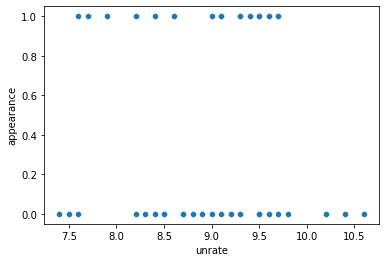

In [5]:
seaborn.scatterplot (data= simplecomp_df, x = simplecomp_df['unrate'], y = simplecomp_df['appearance'])

### Logistic Regression on unemployment rate and whether or not the award Pitbull recieved in a given year was Latin or not

In [6]:
unemployaward_df = pd.read_csv('unemployaward_df.csv')
unemployaward_df[['unrate','Latin']]
y= unemployaward_df['Latin']
x= unemployaward_df['unrate'].values.reshape(-1,1)
x_train = x[:-20]
x_test = x[-20:]
y_train = y[:-20]
y_test = y[-20:]
pitbullaward_logreg = LogisticRegression()
pitbullaward_logreg.fit(x_train, y_train)
print (pitbullaward_logreg.coef_, pitbullaward_logreg.intercept_)

[[-0.57807914]] [3.97474388]


<AxesSubplot:xlabel='unrate', ylabel='Latin'>

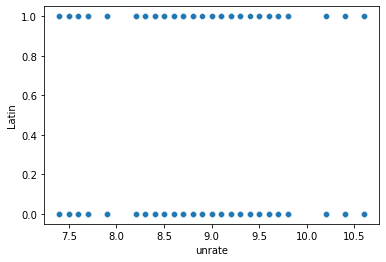

In [7]:
seaborn.scatterplot (data= unemployaward_df, x = unemployaward_df['unrate'], y = unemployaward_df['Latin'])

### Linear Regression on the rate of unemployment and the frequency of the song on Hot100

In [8]:
x= simplecomp_df['unrate']
y= simplecomp_df['songfreq']
x= np.array(x.values).reshape(-1,1)
y= np.array(y.values).reshape(-1,1)
linx_train = x[:-20]
linx_test = x[-20:]
liny_train = y[:-20]
liny_test = y[-20:]
pitbull_linreg = LinearRegression()
pitbull_linreg.fit(linx_train, liny_train)
slope= float(pitbull_linreg.coef_)
intercept= float(pitbull_linreg.intercept_)
print ("The model's slope is", slope)
print ('Intercept:', intercept)

The model's slope is -0.26920611665598465
Intercept: 4.4502334951011875


### Time Series Concerning Pitbull's Song Frequency on Billboard Hot 100 Between 2009 and 2012

In [9]:
simplecomp_df.head(5)

,Unnamed: 0,year,date,appearance,month,unrate,songfreq
0,0,2009,2009-01-01,0,1,8.5,0.0
1,1,2009,2009-02-01,0,2,8.9,0.0
2,2,2009,2009-03-01,1,3,9.0,3.0
3,3,2009,2009-04-01,1,4,8.6,4.0
4,4,2009,2009-05-01,1,5,9.1,5.0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

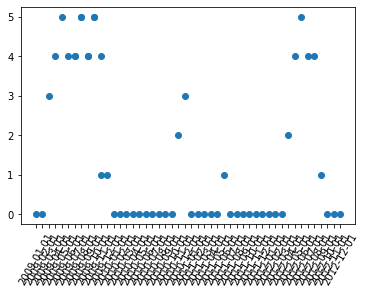

In [10]:
plt.scatter('date','songfreq', data=simplecomp_df)
plt.xticks(rotation=60)

### Time Series Concerning Unemployment Between 2009 and 2012

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

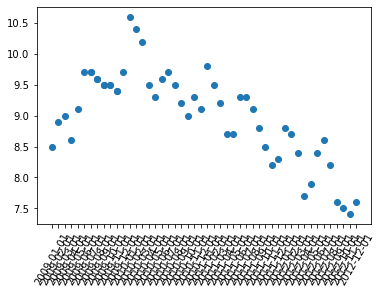

In [11]:
plt.scatter('date','unrate', data=simplecomp_df)
plt.xticks(rotation=60)

### Exploratory data: Finding out the mean, median, variance, standard deviation of data concerning unemployment and Pitbull's appearances on Billboard Hot 100 

Exploratory data concerning the frequency of Pitbull's music on Hot 100

In [12]:
billboard_freq_means = (simplecomp_df['songfreq'].mean(axis=0))
print ('billboard_freq_means')
print (billboard_freq_means)
billboard_freq_median= (simplecomp_df['songfreq'].median(axis=0))
print ('billboard_freq_median')
print (billboard_freq_median)
billboard_freq_variances= (simplecomp_df['songfreq'].var(axis=0))
print ('billboard_freq_variances')
print (billboard_freq_variances)
billboard_freq_std= (simplecomp_df['songfreq'].std(axis=0))
print ('billboard_freq_std')
print (billboard_freq_std)

billboard_freq_means
1.5849056603773586
billboard_freq_median
0.0
billboard_freq_variances
3.978229317851962
billboard_freq_std
1.9945499035752305


Exploratory data concerning the unemployment rate between 2009 and 2012

In [13]:
unrate_means = (simplecomp_df['unrate'].mean(axis=0))
print ('unrate_means')
print (unrate_means)
unrate_median= (simplecomp_df['unrate'].median(axis=0))
print ('unrate_median')
print (unrate_median)
unrate_variances= (simplecomp_df['unrate'].var(axis=0))
print ('unrate_variances')
print (unrate_variances)
unrate_std= (simplecomp_df['unrate'].std(axis=0))
print ('unrate_std')
print (unrate_std)

unrate_means
9.028301886792452
unrate_median
9.2
unrate_variances
0.537068214804064
unrate_std
0.732849380707976


## Summarizing Phase II

### Data description. Have an initial draft of your data description section.

#### Summary

Our data consists of csv files from Kaggle, noting unemployment data and Billboard Hot 100 data. Additionally, we underwent webscraping to collect Wikipedia data on Pitbull's billboard awards.The unemployment data we needed to remove NaN values and bound the dates in between 2009 and 2012. Additionally, we needed to merge the month and date columns so we could do a time series. The same could be said for the Billboard Hot 100 file, because we needed to merge the month and the data. We also had to make sure that the only artist we accounted for was Pitbull. The Pitbull awards data scraping involved using two Wikipedia tables to create a fuller picture of how successful he was according to the Billboard awards. This meant that we added an additional column regarding whether or not the award won was for the Billboard Latin Awards or the Billboard Awards. 

#### Detailed Information

- The unemployment dataset was created to keep track of unemployment rate as an economic measure; the Wikipedia page for Pitbull's Billboard awards was likely created as a general information source for the public to learn about Pitbull as an artist and public figure; we are unsure about what the motivation was for creating the Billboard Hot 100 dataset other than to keep track of which songs appear on there and how often.

- Although we used the unemployment dataset from Kaggle, the data is the same as in FRED (Federal Reserve Economic Data) and is government-funded, Wikipedia pages are usually funded through indvidual donations and volunteer contributions, and we are unsure of where the funding comes from (if any) for the Billboard Hot 100 dataset from Kaggle.

- Since the Billboard Hot 100 data on Kaggle does not explicitly mention how the data is collected, and billboard.com (listed as the provenance) does not have a way to view past weeks, this can be a source of many human errors, including missing details from a given week or inputting incorrect details from manual data input (if the inpur process was manual). As for the unemployment dataset, the actual collection of such data can be found here: https://www.bls.gov/cps/cps_htgm.htm, but the main processes that would affect the recording process would be in the sample selection itself, which may result in the over-generalization of unemployment rate numbers. As for the Wikipedia page, any contributor must rely on other sources of data available to be reliable in order to compile those pieces of data into one page, in this case Billboard Awards.

- Although we are unsure of what and how preprocessing was performed on any of these datasets, we do know that data had to be transferred from a different site (FRED and Billboard) into the datasets that we downloaded, which can have various problems as discussed previously.

- For the unemployment data, people were aware of the data collection and probably expected it to be used for government purposes, which it was, though they may have not predicted it would be used to study correlation between unemployment and Pitbull popularity.

### Data limitations. Identify any potential problems with your dataset.

 It could be very limited, because there are other metrics for popularity than Billboard Hot 100, like Spotify and Apple music. Additionally, because it's so niche, there is not a large amount of Pitbull popularity to draw on. Moreover, we may need to do some transformations to nomalize our values. We may also need to figure out how to utilize our test set without overusing it. We're trying to avoid overfitting.

### Exploratory data analysis. Perform an (initial) exploratory data analysis.

It shows pretty weak correlation. When we go off our logistic regressions with the binaries-- whether or not he appeared on the charts and whether or not an award was Latin or not, there's no definitive way to predict the unemployment rate. We need to utilize more analysis tools to see to our ends. Nevertheless, the time series do seem a little promising, given they have some points that seem to overlaps. The mean, median, variance, and standard deviation for the song frequency do not seem the most promising, because the variance is so high, while the unemployment rate variance is so low, being <1.

### Questions for reviewers. List specific questions for your peer reviewers


- How can we make this more substantive?
- How can we implement the awards dataframe in a manner to tell a story with data?
- What do you suggest we transform and how can we normalize our data to work better together? 


### Phase III 

Our initial exploratory data analysis revealed a lot of variation, but we believe that given select factors, we can find some correlation between Pitbull's success as an artist as indicative of unemployment trends in from 2009-2012.

Hypothesis #1- There's a correlation between an award in a given year being Latin and the unemployment rate fluctuating by a certain amount from 2009 to 2012.
- We will perform a pmf on the probability that given a song's award is Latin, the unemployment rate would fluctuate by a certain amount.
- We will also utilize a correlation matrix.

Hypothesis #2- Given a host of variables in our unemployment data-- age range of those unemployed, their gender, and the cumulative unemployment rate-- we can predict whether or not Pitbull would make it onto the Billboard Charts.
 - We will do a train-test split logistical regression to see if we can train the data set on unemployment-- given a host of variables-- to see if we can predict Pitbull's chart success.

Questions for reviewers-

- How do we utilize the awards df better? Is a pmf function the best course of action, or should we utilize something else?
- Instead of a train-test split, should we utilize K-folds for hypothesis #2, because our data set is so small?

### Phase IV

Hypothesis #1- There's a correlation between an award in a given year being Latin and the unemployment rate fluctuating by a certain amount from 2009 to 2012.
- We will perform a pmf on the probability that given a song's award is Latin, the unemployment rate would fluctuate by a certain amount.
- We will also utilize a correlation matrix.

In [15]:
unemployaward_df['Latin'].value_counts

<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
895    1
896    1
897    1
898    1
899    1
Name: Latin, Length: 900, dtype: int64>